# Проект: Обучение с учителем: качество модели

Описание проекта и задачи

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Загрузка данных

Импортируем необходимые инструменты

In [1]:
!pip install phik 
!pip install shap 

import numpy as np
import pandas as pd
from scipy import stats as st 
from matplotlib import pyplot as plt
import seaborn as sns 
import shap
import phik
import warnings
warnings.filterwarnings("ignore")

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


RANDOM_STATE = 42
TEST_SIZE = 0.25

Загрузим файлы с данными в формат pd.DataFrame

In [2]:
market_file = pd.read_csv('market_file.csv')
market_file.info()
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [3]:
market_money = pd.read_csv('market_money.csv')
market_money.info()
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [4]:
market_time = pd.read_csv('market_time.csv')
market_time.info()
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [5]:
money = pd.read_csv('money.csv', sep=';', decimal=',')
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Вывод по шагу 1

Файлы с данными были загружены в pd.DataFrame. Данные в таблицах соответствуют описанию.

## Предобработка данных

Рассмотрим каждый датафрейм по отдельности, оценим уникальные значения и скорректируем выявленные ошибки.

Рассмотрим датафрейм market_file, приведем названия столбцов к "змеиному" типу, проверим на наличие дубликатов.

In [6]:
market_file.rename(columns={'Покупательская активность':'Покупательская_активность', 'Тип сервиса':'Тип_сервиса',
                           'Разрешить сообщать':'Разрешить_сообщать'}, inplace=True)

In [7]:
market_file.duplicated().sum()

0

In [8]:
market_file['Покупательская_активность'].value_counts()

Покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

In [9]:
market_file['Тип_сервиса'].value_counts()

Тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

В признаке Тип_сервиса присутствует 10 значений "стандартт", что явно является ошибочным написанием значения "стандарт". Скорректируем эту ошибку.

In [10]:
market_file['Тип_сервиса'].replace('стандартт', 'стандарт', inplace=True)
market_file['Тип_сервиса'].value_counts()

Тип_сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

In [11]:
market_file['Разрешить_сообщать'].value_counts()

Разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64

In [12]:
market_file['Популярная_категория'].value_counts()

Популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

In [13]:
market_file['Маркет_актив_6_мес'].value_counts()

Маркет_актив_6_мес
4.1    94
3.9    83
4.4    82
4.0    71
5.5    68
4.3    66
4.9    60
3.5    50
4.6    49
3.3    47
4.2    43
2.4    42
3.8    39
4.7    37
4.8    33
3.4    33
5.1    32
3.6    30
5.7    28
5.8    27
5.3    27
5.6    25
5.2    25
5.4    23
2.6    20
3.0    16
3.1    16
5.0    13
3.7    12
6.3    12
6.6    12
6.1    12
1.7    12
0.9    11
3.2    11
1.5     8
2.7     8
2.9     7
4.5     6
1.4     5
5.9     5
Name: count, dtype: int64

In [14]:
market_file['Маркет_актив_тек_мес'].value_counts()

Маркет_актив_тек_мес
4    669
5    323
3    308
Name: count, dtype: int64

In [15]:
set(market_file['Длительность'].unique())

{110,
 121,
 125,
 129,
 131,
 132,
 133,
 134,
 135,
 136,
 140,
 142,
 145,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 157,
 159,
 160,
 161,
 162,
 163,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 184,
 185,
 186,
 187,
 188,
 190,
 191,
 192,
 196,
 199,
 201,
 202,
 203,
 205,
 206,
 207,
 208,
 209,
 211,
 212,
 213,
 215,
 216,
 217,
 219,
 220,
 225,
 226,
 228,
 233,
 234,
 237,
 238,
 242,
 243,
 244,
 245,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 259,
 260,
 261,
 264,
 265,
 267,
 268,
 269,
 271,
 272,
 274,
 275,
 280,
 282,
 283,
 284,
 286,
 290,
 291,
 293,
 296,
 297,
 298,
 300,
 301,
 302,
 304,
 306,
 307,
 308,
 311,
 312,
 316,
 318,
 319,
 320,
 321,
 322,
 324,
 326,
 327,
 330,
 332,
 334,
 335,
 336,
 337,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 355,
 356,
 360,
 362,
 365,
 368,
 370,
 371,
 372,
 373,
 374,
 375,
 377,
 378,
 379,
 380,
 382,
 384,
 387

In [16]:
set(market_file['id'].unique())

{215348,
 215349,
 215350,
 215351,
 215352,
 215353,
 215354,
 215355,
 215356,
 215357,
 215358,
 215359,
 215360,
 215361,
 215362,
 215363,
 215364,
 215365,
 215366,
 215367,
 215368,
 215369,
 215370,
 215371,
 215372,
 215373,
 215374,
 215375,
 215376,
 215377,
 215378,
 215379,
 215380,
 215381,
 215382,
 215383,
 215384,
 215385,
 215386,
 215387,
 215388,
 215389,
 215390,
 215391,
 215392,
 215393,
 215394,
 215395,
 215396,
 215397,
 215398,
 215399,
 215400,
 215401,
 215402,
 215403,
 215404,
 215405,
 215406,
 215407,
 215408,
 215409,
 215410,
 215411,
 215412,
 215413,
 215414,
 215415,
 215416,
 215417,
 215418,
 215419,
 215420,
 215421,
 215422,
 215423,
 215424,
 215425,
 215426,
 215427,
 215428,
 215429,
 215430,
 215431,
 215432,
 215433,
 215434,
 215435,
 215436,
 215437,
 215438,
 215439,
 215440,
 215441,
 215442,
 215443,
 215444,
 215445,
 215446,
 215447,
 215448,
 215449,
 215450,
 215451,
 215452,
 215453,
 215454,
 215455,
 215456,
 215457,
 215458,
 

In [17]:
market_file['Акционные_покупки'].value_counts()

Акционные_покупки
0.24    93
0.30    85
0.28    83
0.17    79
0.25    72
0.14    69
0.21    64
0.13    64
0.16    62
0.23    60
0.15    49
0.94    43
0.22    34
0.11    31
0.40    31
0.99    30
0.27    27
0.35    26
0.95    24
0.26    24
0.18    23
0.20    21
0.12    20
0.32    20
0.29    19
0.93    19
0.39    18
0.98    17
0.89    16
0.33    15
0.19    11
0.36    11
0.90    11
0.31    10
0.91     5
0.34     5
0.00     3
0.44     2
0.60     1
0.75     1
0.74     1
0.47     1
Name: count, dtype: int64

In [18]:
market_file['Средний_просмотр_категорий_за_визит'].value_counts()

Средний_просмотр_категорий_за_визит
3    356
2    312
4    263
5    177
1    106
6     86
Name: count, dtype: int64

In [19]:
market_file['Неоплаченные_продукты_штук_квартал'].value_counts()

Неоплаченные_продукты_штук_квартал
2     261
1     261
3     218
4     197
5     135
0     116
6      44
7      34
8      20
9      10
10      4
Name: count, dtype: int64

In [20]:
market_file['Ошибка_сервиса'].value_counts()

Ошибка_сервиса
4    257
3    226
5    208
2    189
6    156
7     92
1     74
8     66
0     17
9     15
Name: count, dtype: int64

In [21]:
market_file['Страниц_за_визит'].value_counts()

Страниц_за_визит
6     127
5     115
4     112
8     109
9     108
10    104
7     102
11     92
3      76
12     73
13     61
2      58
14     53
15     36
16     21
1      20
17     19
18      7
19      5
20      2
Name: count, dtype: int64

In [22]:
market_money.duplicated().sum()

0

In [23]:
market_money['Период'].value_counts()

Период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

Рассмотрим датафрейм market_money, выявим и скорректируем ошибки.

In [24]:
set(market_money['Выручка'].unique())

{0.0,
 4885.7,
 4885.6,
 4887.4,
 4887.0,
 4889.6,
 4890.5,
 4891.8,
 4892.0,
 4893.9,
 4894.0,
 4895.6,
 4897.8,
 4898.8,
 4899.0,
 4902.0,
 4902.2,
 4904.6,
 4906.0,
 4906.5,
 4907.0,
 4907.8,
 4910.0,
 4912.2,
 4912.5,
 4913.7,
 4913.2,
 4915.5,
 4917.8,
 4919.5,
 4920.0,
 4923.5,
 4923.4,
 4924.8,
 4925.8,
 4926.4,
 4927.0,
 4928.8,
 4931.8,
 4931.5,
 4936.0,
 4937.2,
 4937.6,
 4938.6,
 4941.0,
 4942.6,
 4943.1,
 4946.5,
 4946.0,
 4949.1,
 4949.0,
 4951.0,
 4954.0,
 106862.2,
 4958.0,
 4959.0,
 4959.2,
 4960.0,
 4960.7,
 4961.0,
 4962.2,
 4963.1,
 4965.4,
 4966.0,
 4968.4,
 4969.1,
 4970.0,
 4973.5,
 4973.0,
 4975.5,
 4979.0,
 4980.0,
 4981.0,
 4983.3,
 4984.1,
 4985.5,
 4986.0,
 4988.0,
 4988.5,
 4989.8,
 4989.6,
 4991.4,
 4994.0,
 4996.4,
 4999.8,
 4999.3,
 5000.0,
 5001.2,
 5005.9,
 5005.0,
 5006.8,
 5007.6,
 5007.0,
 5007.9,
 5009.5,
 5011.0,
 5014.0,
 5014.2,
 5018.0,
 5019.9,
 5020.8,
 5021.3,
 5026.0,
 5027.0,
 5028.5,
 5029.4,
 5030.0,
 5031.4,
 5033.4,
 5037.5,
 5039.6,
 5

In [25]:
market_time.duplicated().sum()

0

In [26]:
market_time['Период'].value_counts()

Период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

Значение "предыдцщий месяц" явно является ошибочным написанием значения "предыдущий месяц"

In [27]:
market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц', inplace=True)
market_time['Период'].value_counts()

Период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64

In [28]:
money.duplicated().sum()

0

In [29]:
set(money['Прибыль'].unique())

{0.86,
 0.98,
 1.06,
 1.08,
 1.33,
 1.37,
 1.38,
 1.39,
 1.4,
 1.48,
 1.54,
 1.55,
 1.57,
 1.63,
 1.64,
 1.68,
 1.81,
 1.82,
 1.83,
 1.84,
 1.87,
 1.92,
 1.95,
 1.97,
 2.0,
 2.02,
 2.03,
 2.07,
 2.08,
 2.09,
 2.1,
 2.11,
 2.13,
 2.15,
 2.16,
 2.18,
 2.19,
 2.21,
 2.23,
 2.24,
 2.26,
 2.27,
 2.29,
 2.32,
 2.33,
 2.34,
 2.35,
 2.36,
 2.37,
 2.38,
 2.39,
 2.41,
 2.42,
 2.43,
 2.44,
 2.45,
 2.46,
 2.47,
 2.48,
 2.49,
 2.5,
 2.51,
 2.53,
 2.54,
 2.55,
 2.57,
 2.59,
 2.6,
 2.61,
 2.63,
 2.64,
 2.66,
 2.67,
 2.68,
 2.69,
 2.7,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.19,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42

В рамках второго этапа были скорректированы названия стобцов датафрейма market_file, исправлены явные ошибки в категориальных признаках.

## Исследовательский анализ данных

Проведем исследования данных, представленных в датафреймах. Начнем с датафрейма market_file

In [30]:
market_file.info()
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [31]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Аномальных значений не выявлено, отобразим значения признаков по столбцам в графическом виде.

In [32]:
market_file.select_dtypes(include='number').columns

Index(['id', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [33]:
market_file.select_dtypes(exclude='number').columns

Index(['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Популярная_категория'],
      dtype='object')

In [34]:
num_col_market =  market_file.select_dtypes(include='number').columns.tolist()[1:]

cat_col_market = market_file.select_dtypes(exclude='number').columns.tolist()

[
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит'
]

[
    'Покупательская_активность',
    'Тип_сервиса',
    'Разрешить_сообщать',
    'Популярная_категория'
]

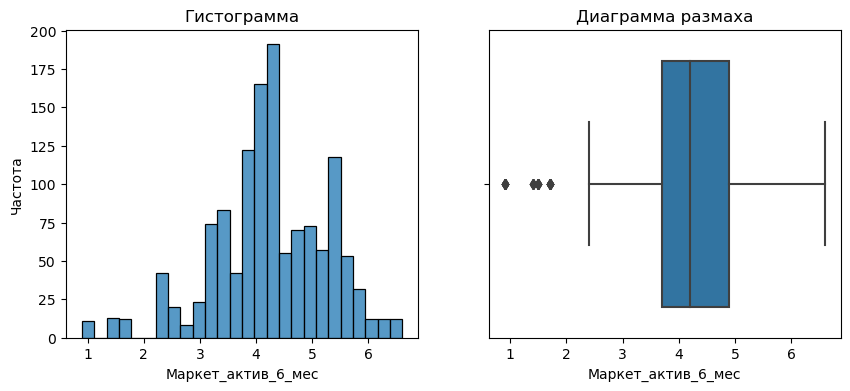

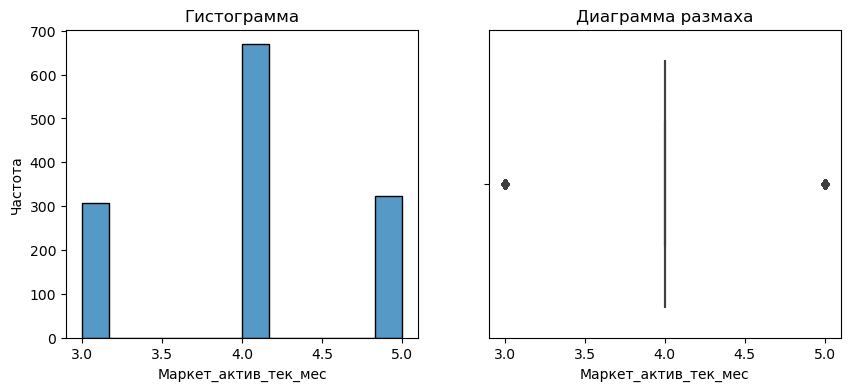

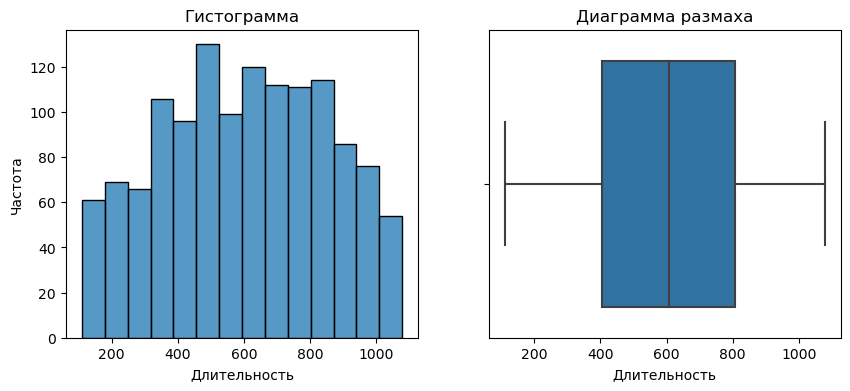

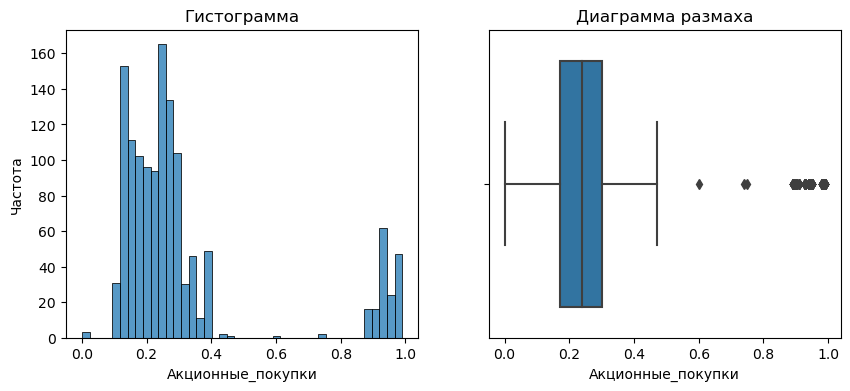

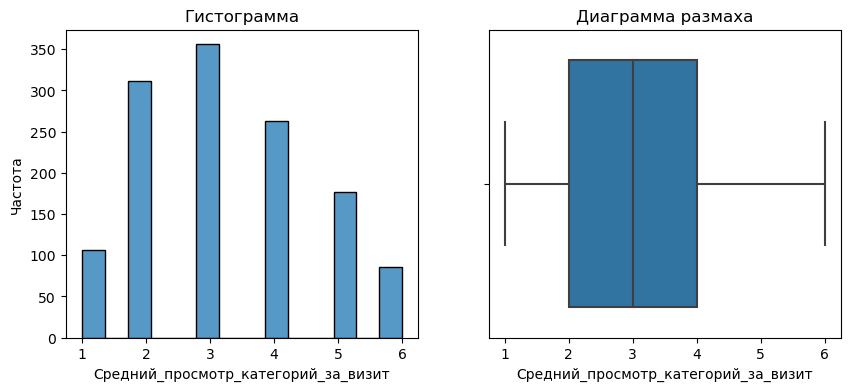

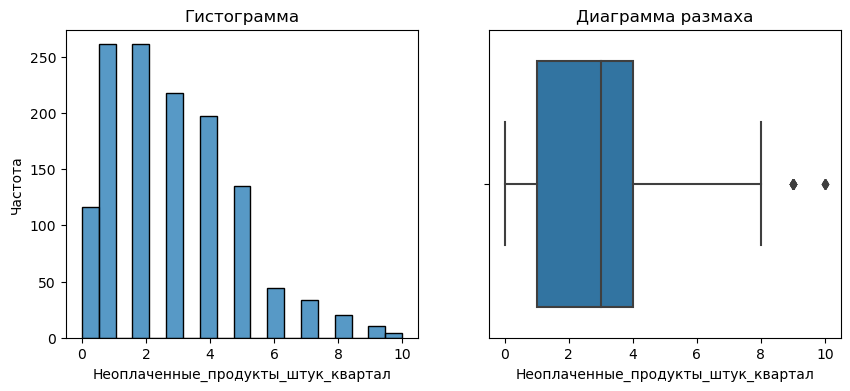

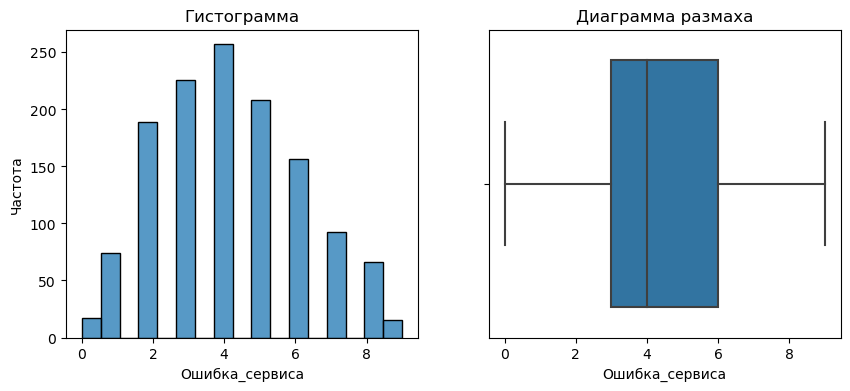

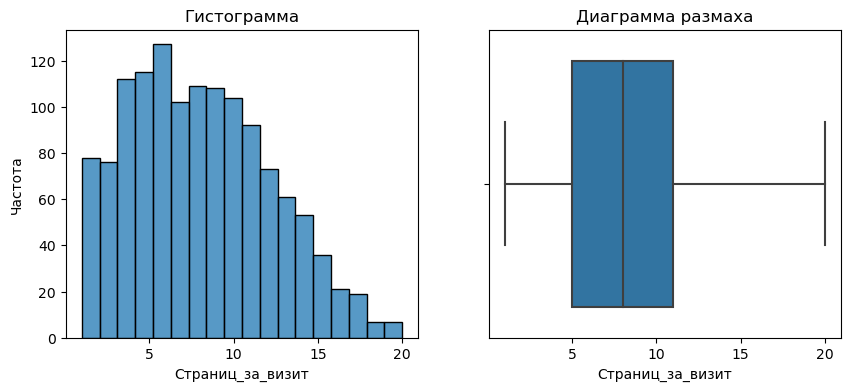

In [35]:
for col in num_col_market:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.title('Гистограмма')
    sns.histplot(market_file[col])
    plt.subplot(1, 2, 2)
    plt.xlabel(col)
    plt.title('Диаграмма размаха')
    sns.boxplot(x=market_file[col])

Признаки Маркет_актив_6_мес, Длительность и Страниц_за_визит распределены нормально. Количественные признаки Ошибка_сервиса, Неоплаченные_продукты_штук_квартал, Средний_просмотр_категорий_за_визит, Маркет_актив_тек_мес можно было бы перевести в категориальные.

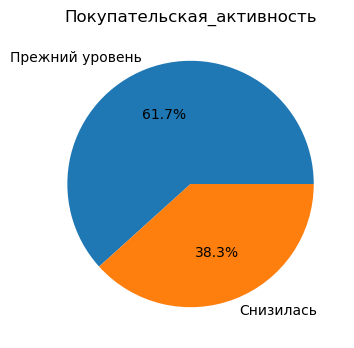

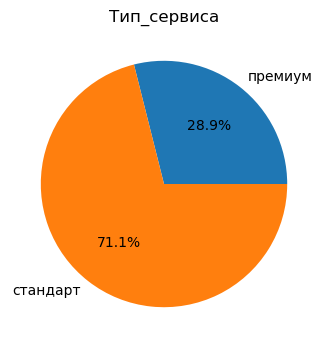

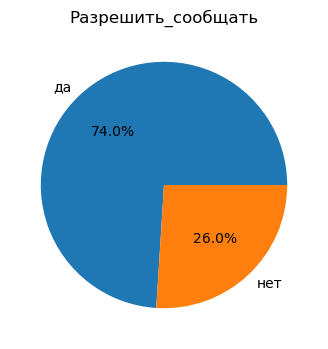

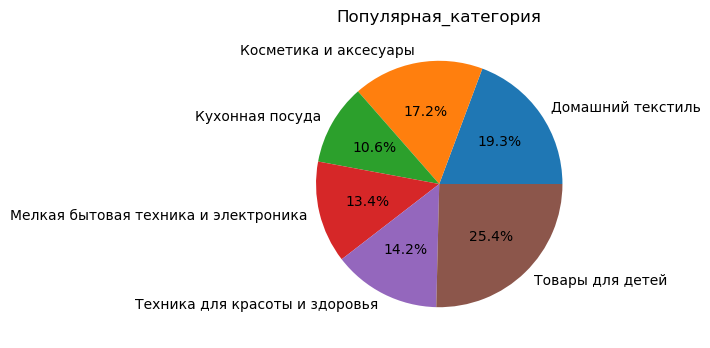

In [36]:
for col in cat_col_market:
    plt.figure(figsize=(10, 4))
    plt.title(col)
    plt.pie(x=market_file.groupby(col)['id'].count(), autopct='%1.1f%%', labels=market_file.groupby(col)['id'].count().index)

Аномалий в распределении категориальных признаков нет, целевой признак распределен неравномерно, необходимо учитывать этот факт при выборе моделей.

In [37]:
market_money.info()
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [38]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Анализ показал наличие выбросов (большое максимальное значение) и нулевое значение признака, определим покупателей с подобными значениями признака Выручка.

In [39]:
market_money[market_money['Выручка']>20000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


In [40]:
set(market_money[market_money['Выручка']==0]['id'])

{215348, 215357, 215359}

Удалим этих четырех покупателей из всех датафреймов.

In [41]:
market_money = market_money[~market_money['id'].isin([215380, 215348, 215357, 215359])]
market_file = market_file[~market_file['id'].isin([215380, 215348, 215357, 215359])]
market_time = market_time[~market_time['id'].isin([215380, 215348, 215357, 215359])]
money = money[~money['id'].isin([215380, 215348, 215357, 215359])]
print(market_money.shape, market_file.shape, market_time.shape, money.shape)

(3888, 3) (1296, 13) (2592, 3) (1296, 2)


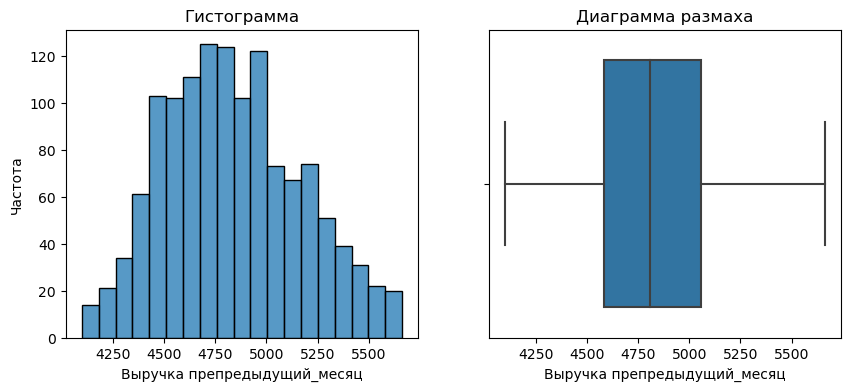

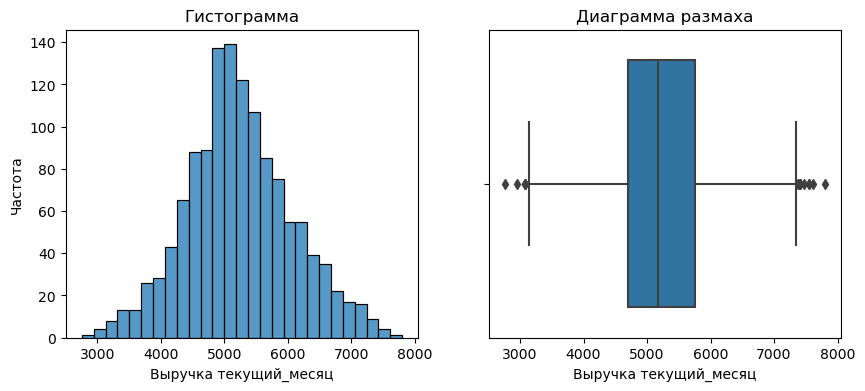

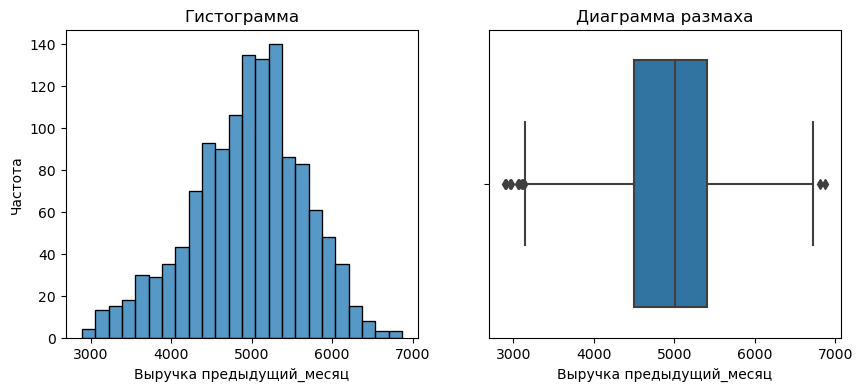

In [42]:
for n in market_money['Период'].unique().tolist():
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.xlabel('Выручка '+ n)
    plt.ylabel('Частота')
    plt.title('Гистограмма')
    sns.histplot(market_money.query('Период == @n')['Выручка'])
    plt.subplot(1, 2, 2)
    plt.title('Диаграмма размаха')
    sns.boxplot(x=market_money.query('Период == @n')['Выручка'])
    plt.xlabel('Выручка '+ n);

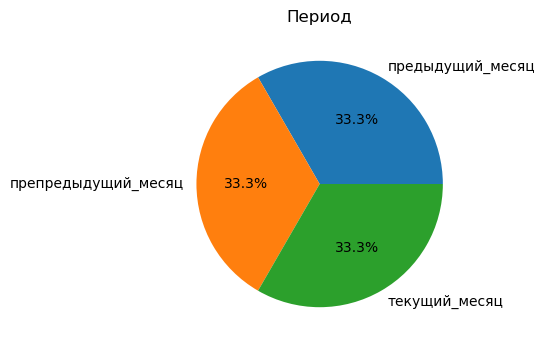

In [43]:
plt.figure(figsize=(10, 4))
plt.title('Период')
plt.pie(x=market_money.groupby('Период')['id'].count(), autopct='%1.1f%%', labels=market_money.groupby('Период')['id'].count().index);

Количественные данные в датафрейме market_money распределены нормально, категориальные - равномерно.

In [44]:
market_time.info()
market_time.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2592 entries, 2 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2592 non-null   int64 
 1   Период  2592 non-null   object
 2   минут   2592 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 81.0+ KB


,id,Период,минут
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдущий_месяц,8
6,215351,текущий_месяц,13


In [45]:
market_time.describe()

,id,минут
count,2592.000000,2592.000000
mean,215999.464506,13.340664
std,374.255617,4.083469
min,215349.000000,4.000000
25%,215675.750000,10.000000
50%,215999.500000,13.000000
75%,216323.250000,16.000000
max,216647.000000,23.000000


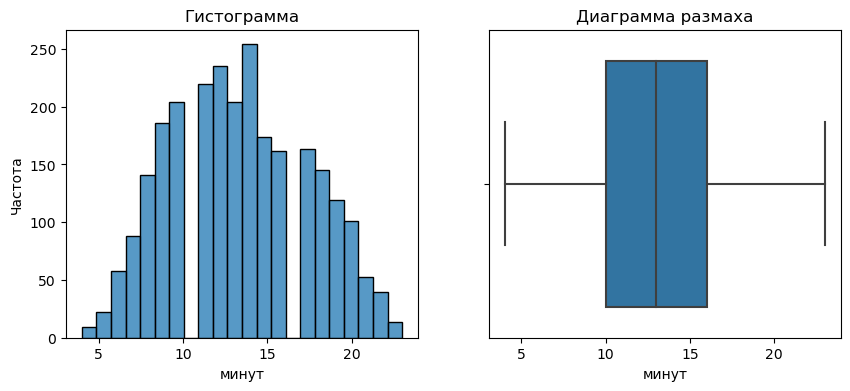

In [46]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.xlabel('минут')
plt.ylabel('Частота')
plt.title('Гистограмма')
sns.histplot(market_time['минут'])
plt.subplot(1, 2, 2)
plt.xlabel('Выручка')
plt.title('Диаграмма размаха')
sns.boxplot(x=market_time['минут']);

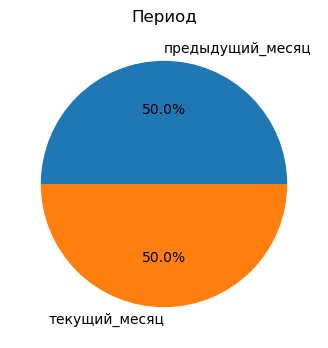

In [47]:
plt.figure(figsize=(10, 4))
plt.title('Период')
plt.pie(x=market_time.groupby('Период')['id'].count(), autopct='%1.1f%%', labels=market_time.groupby('Период')['id'].count().index);

Количественные данные в датафрейме market_time распределены нормально, категориальные - равномерно.

In [48]:
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 1 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1296 non-null   int64  
 1   Прибыль  1296 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 30.4 KB


,id,Прибыль
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95


In [49]:
money.describe()

,id,Прибыль
count,1296.000000,1296.000000
mean,215999.464506,3.997701
std,374.327860,1.011198
min,215349.000000,0.860000
25%,215675.750000,3.300000
50%,215999.500000,4.045000
75%,216323.250000,4.670000
max,216647.000000,7.430000


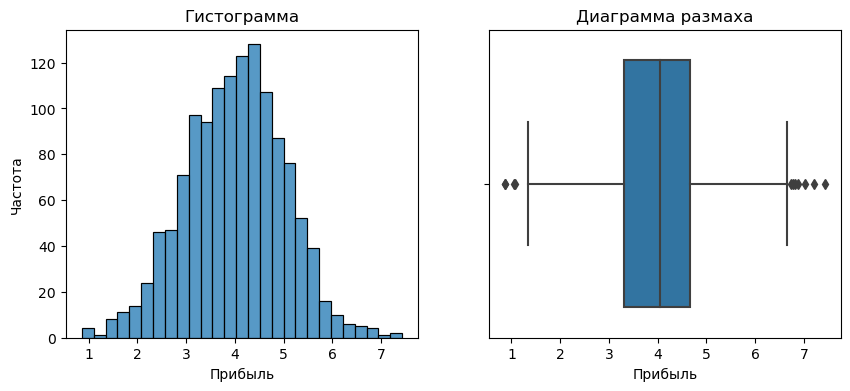

In [50]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.title('Гистограмма')
sns.histplot(money['Прибыль'])
plt.subplot(1, 2, 2)
plt.xlabel('Выручка')
plt.title('Диаграмма размаха')
sns.boxplot(x=money['Прибыль']);

Количественные данные в датафрейме money распределены нормально, категориальные - равномерно.

В рамках проведенного исследовательского анализа были выявлены и устранены покупатели с аномальными значениями в признаке Выручка, остальные данные распределены нормально и равномерно.

## Объединение таблиц

Перед объединением таблиц оценим признак id покупателей в разных датафреймах.

In [51]:
market_file['id'].nunique()

1296

In [52]:
market_money['id'].nunique()

1296

In [53]:
market_time['id'].nunique()

1296

In [54]:
money['id'].nunique()

1296

In [55]:
market_file[~market_file['id'].isin(market_money['id'])]['id'].count()

0

In [56]:
market_file[~market_file['id'].isin(market_time['id'])]['id'].count()

0

In [57]:
market_file[~market_file['id'].isin(money['id'])]['id'].count()

0

Во всех датафреймах представлены 1296 id покупателей, других не выявлено.

Объединим датафреймы market_file, market_money, market_time и money по столбцу id с учетом значений в категориальных столбцах и созданием отдельных столбцов в общем датафрейме.

In [58]:
period = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц'] 
for p in period:
    market_file = market_file.merge(market_money.query('Период == @p'), on='id', how='left')
    new_name_column='Выручка_'+p
    market_file.rename(columns={'Выручка':new_name_column},inplace=True)
market_file = market_file[market_file.columns.drop(list(market_file.filter(regex='Период')))]

In [59]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская_активность            1296 non-null   object 
 2   Тип_сервиса                          1296 non-null   object 
 3   Разрешить_сообщать                   1296 non-null   object 
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

In [60]:
market_file.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_препредыдущий_месяц,Выручка_предыдущий_месяц,Выручка_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5


In [61]:
period = ['предыдущий_месяц', 'текущий_месяц'] 
for p in period:
    market_file = market_file.merge(market_time.query('Период == @p'), on='id', how='left')
    new_name_column = 'минут_'+p
    market_file.rename(columns={'минут':new_name_column},inplace=True)
market_file = market_file[market_file.columns.drop(list(market_file.filter(regex='Период')))]

In [62]:
market_file.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_препредыдущий_месяц,Выручка_предыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


In [63]:
market_file = market_file.merge(money, on='id', how='left')

In [64]:
market_file.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_препредыдущий_месяц,Выручка_предыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,3.95


In [65]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская_активность            1296 non-null   object 
 2   Тип_сервиса                          1296 non-null   object 
 3   Разрешить_сообщать                   1296 non-null   object 
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

Датафреймы market_file, market_money и market_time были объединены по столбцу id с учетом значений в категориальных столбцах и созданием отдельных столбцов в общем датафрейме.

## Корреляционный анализ

Проведем корреляционный анализ с использованием возможностей библиотеки phik

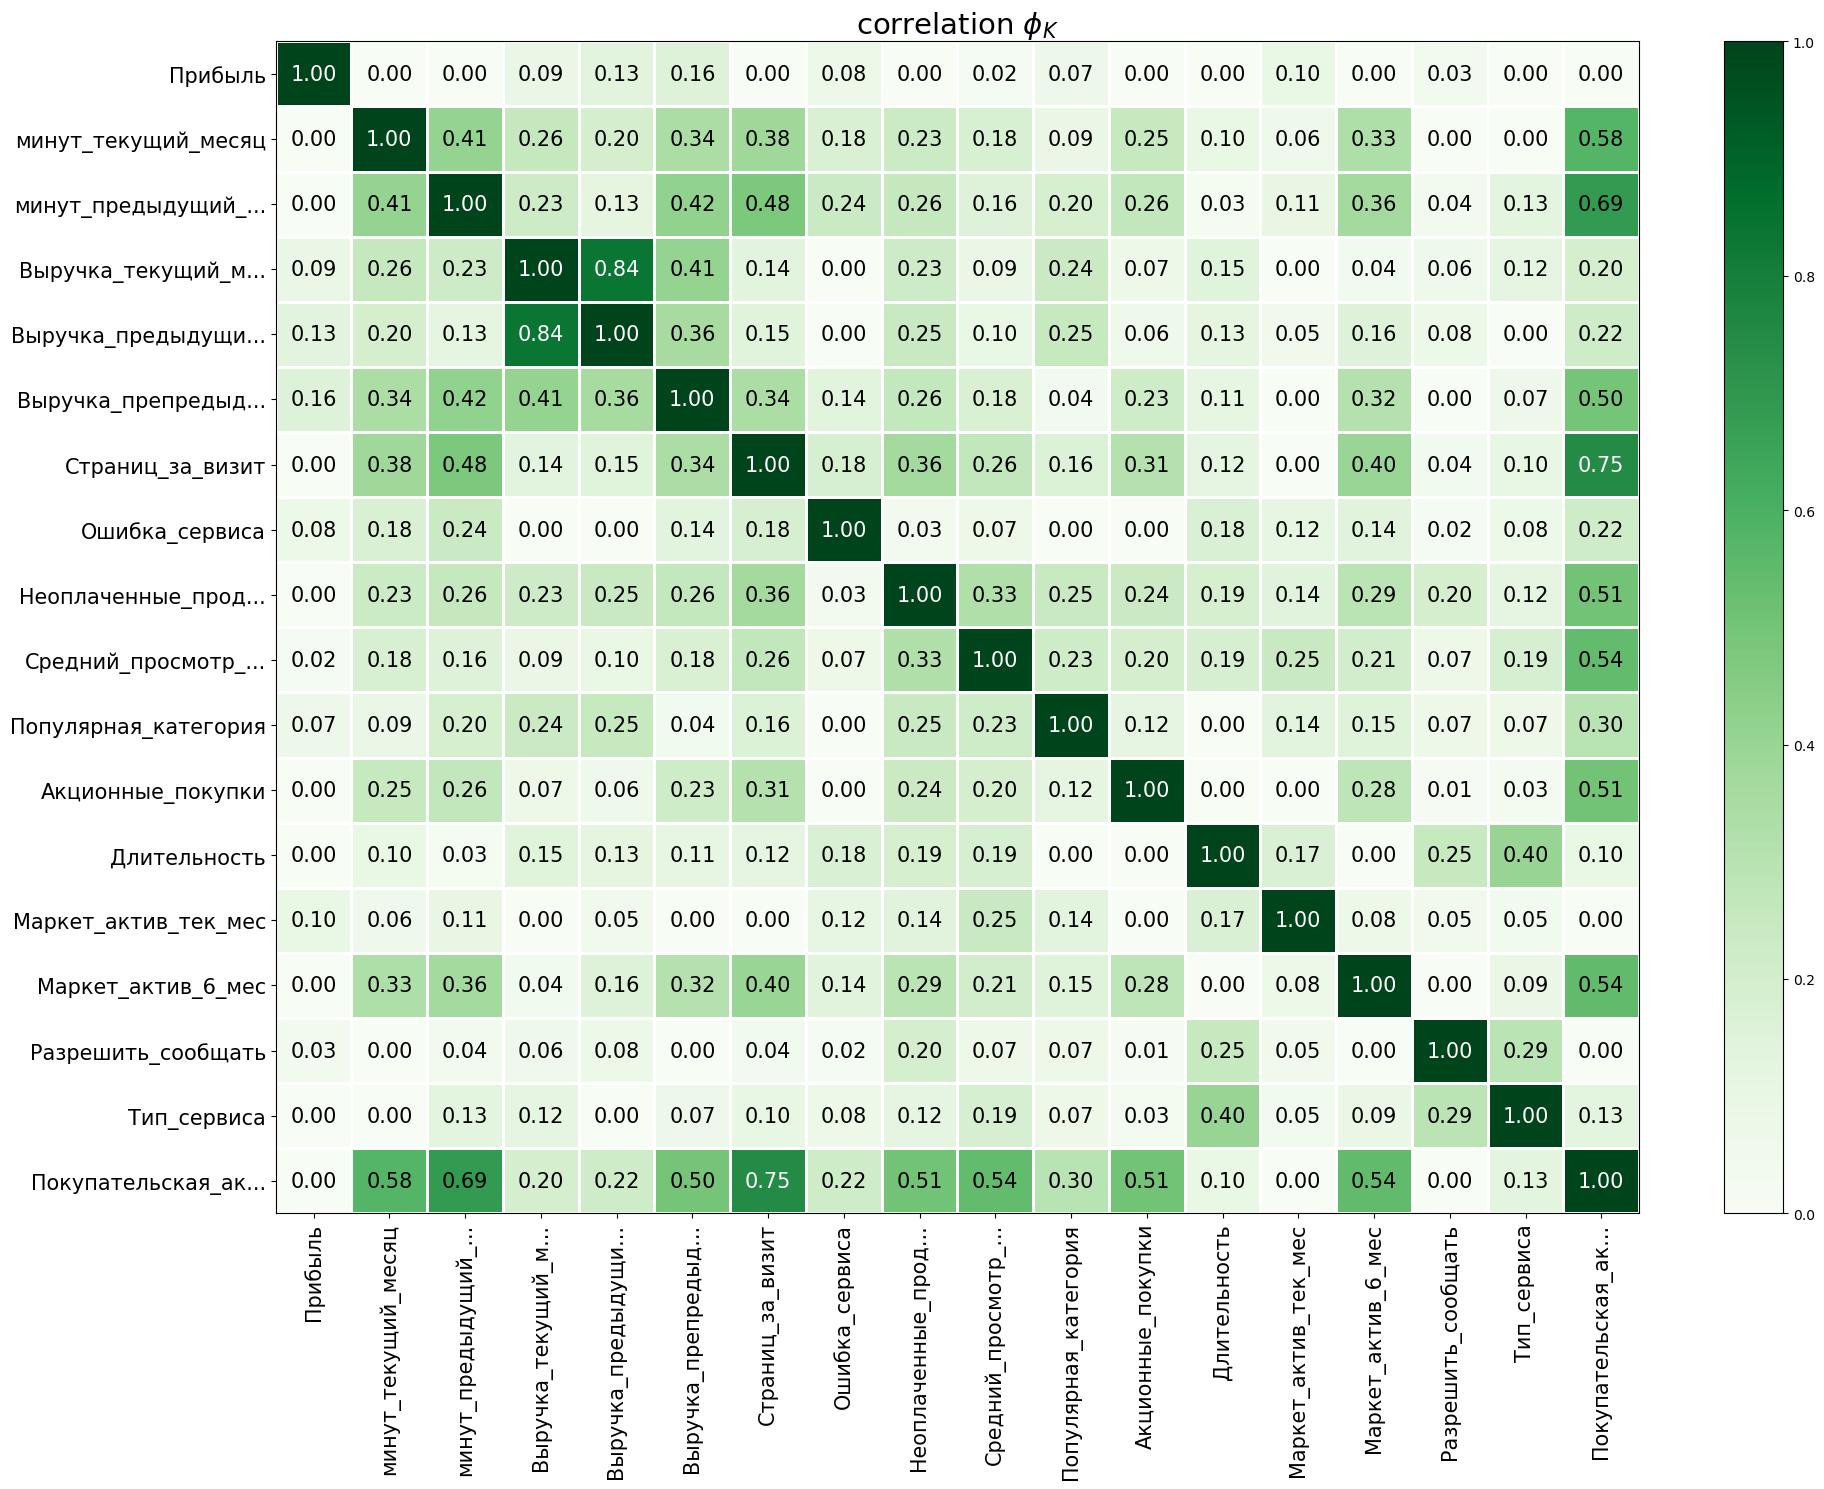

In [66]:
interval_cols = market_file.select_dtypes(include='number').columns.tolist()[1:]
phik_overview = phik_matrix(market_file.drop('id', axis=1), interval_cols=interval_cols) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Выявлены признаки мультиколлинеарности между признаками Выручка текущий и Выручка предыдущий. Обратим внимание на коэффициенты корреляции целевого признака с признаками минут_предыдущий месяц и страниц_за_визит(0.69 и 0.75). Возможно, модель будет уделять повышенное внимание этим признакам в ущерб остальным.


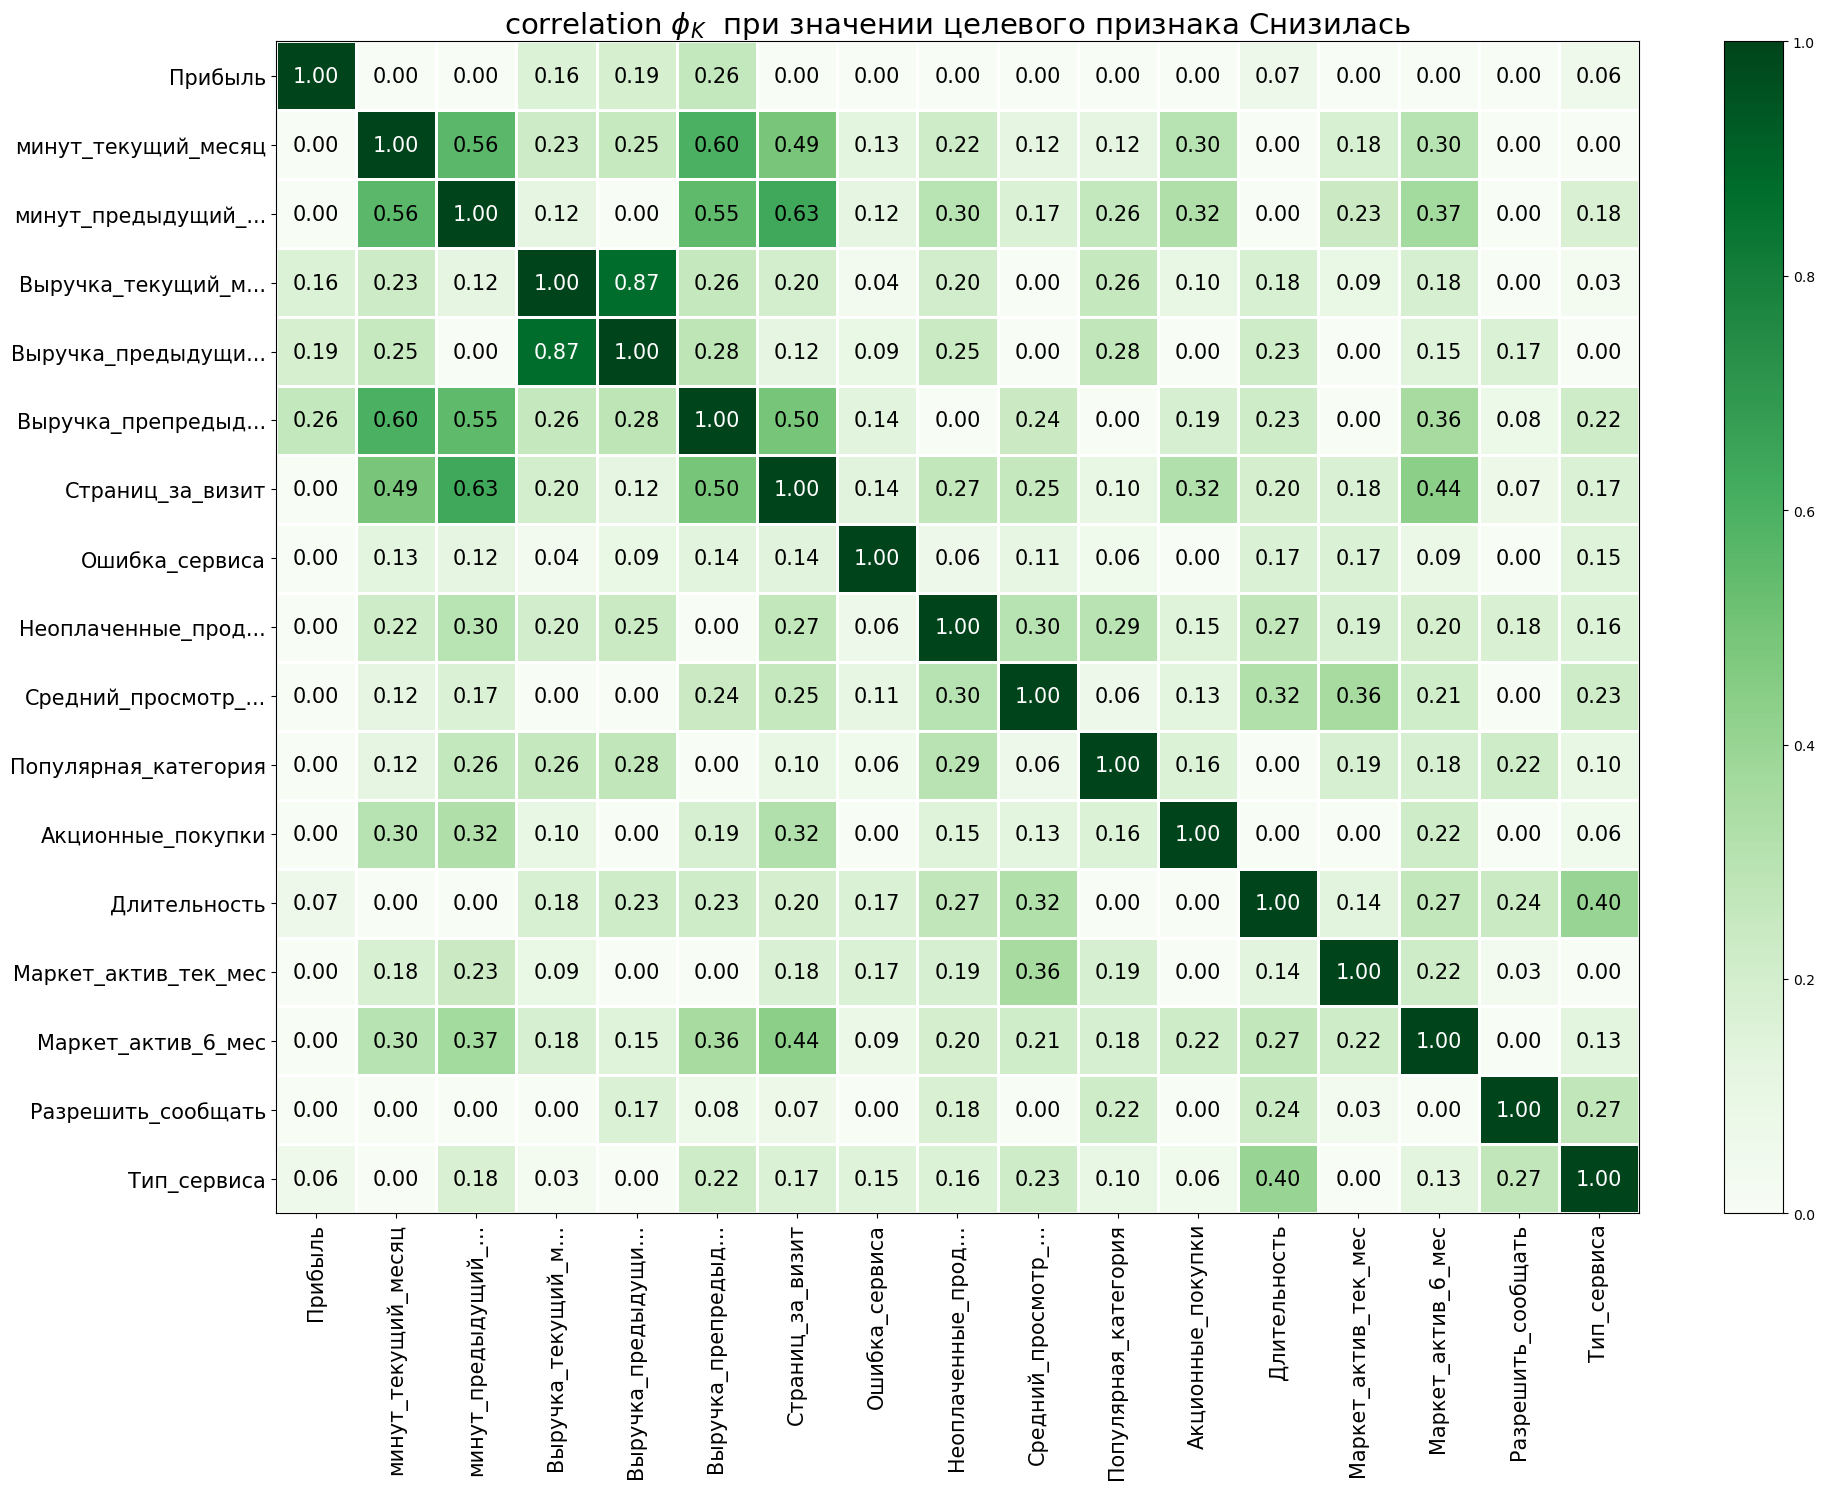

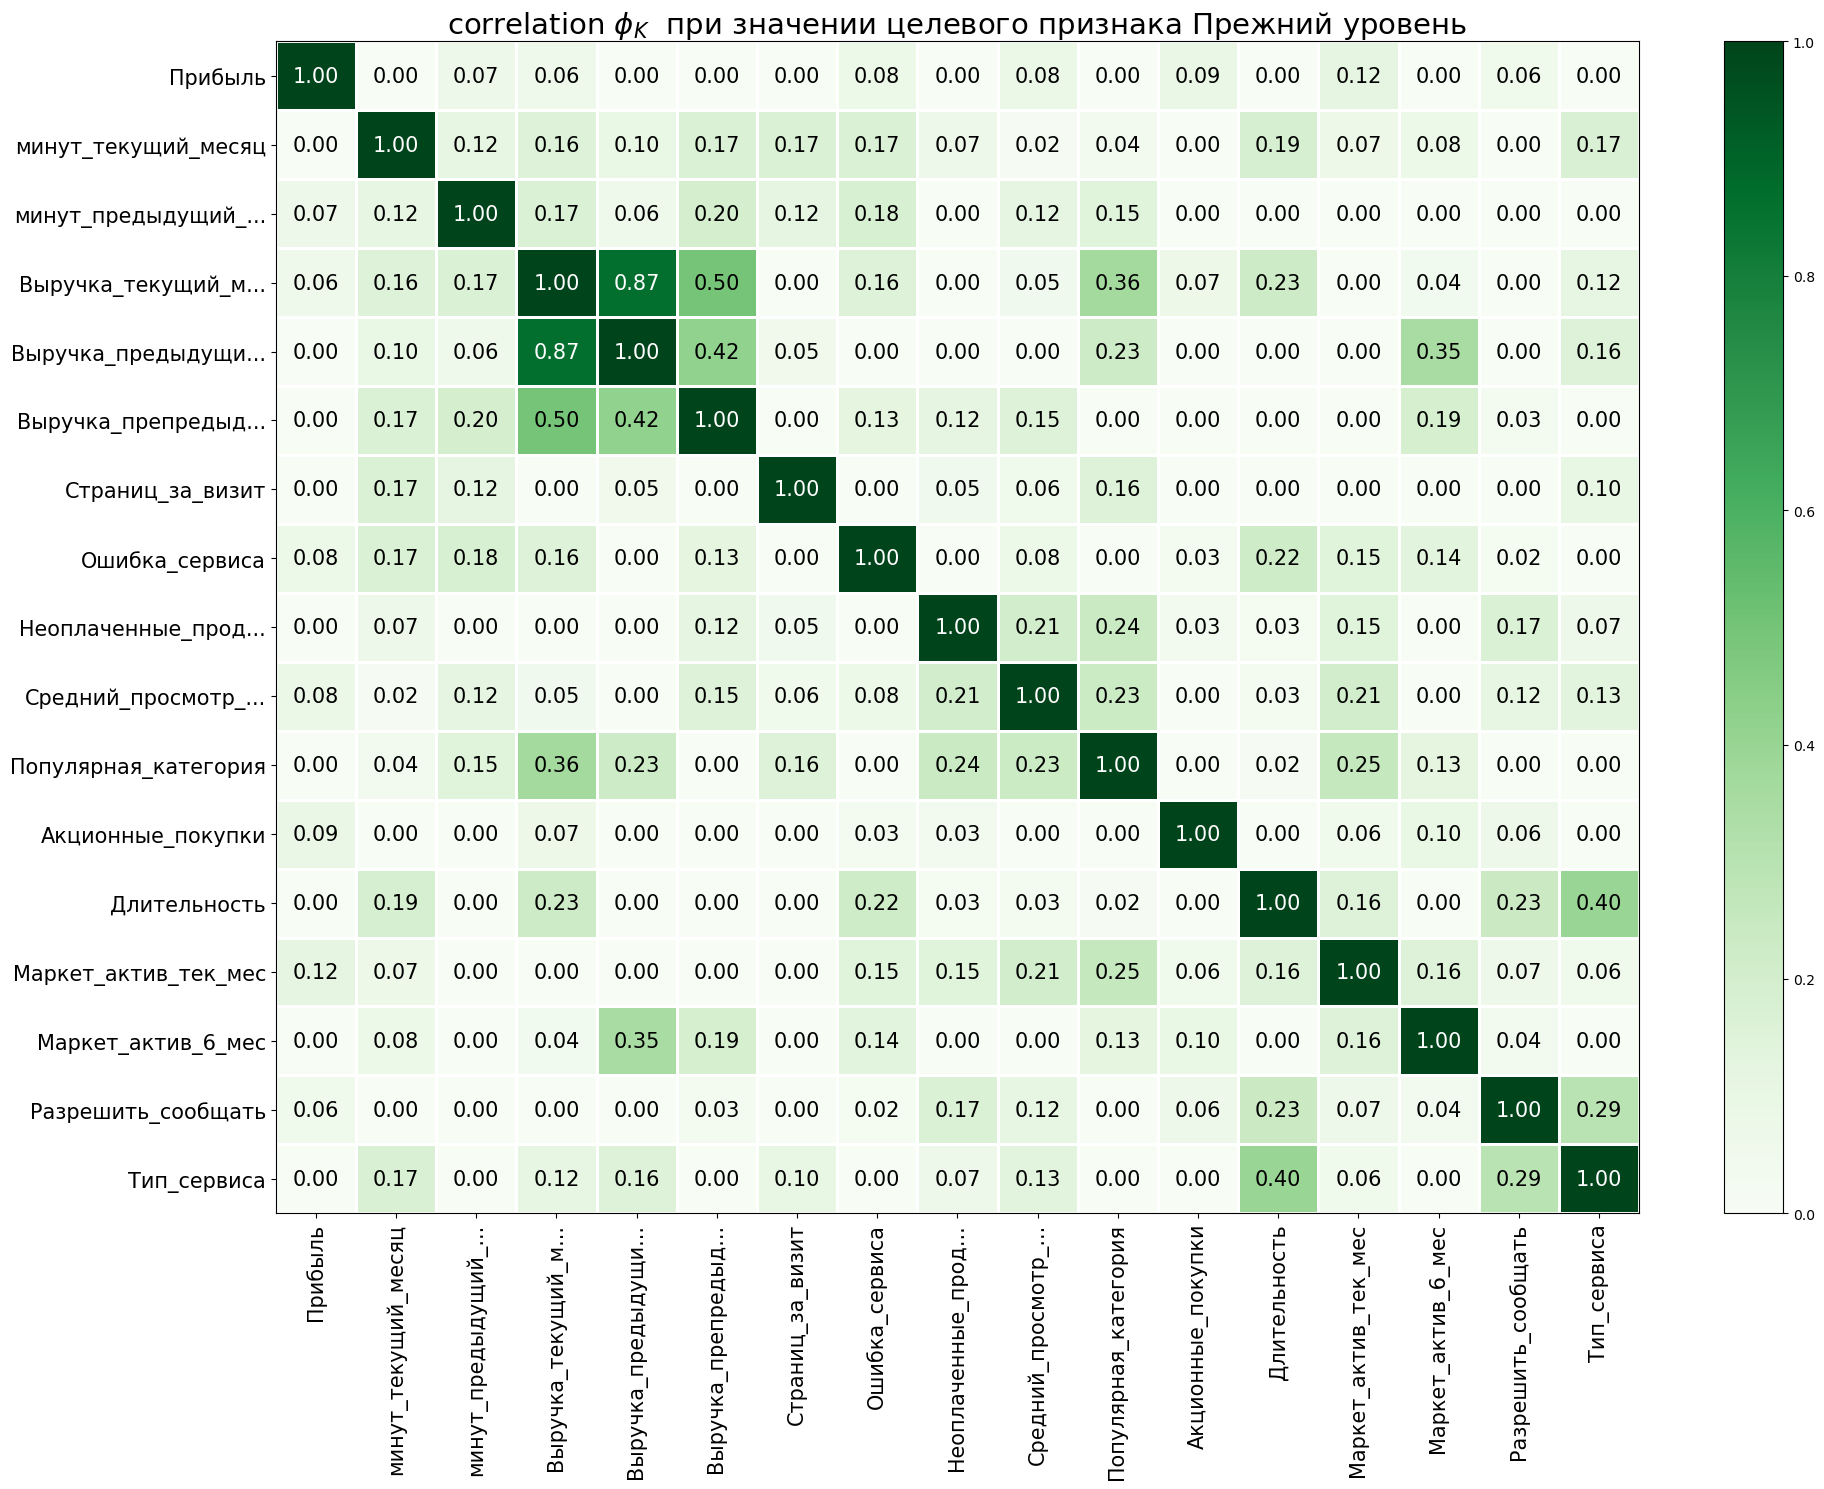

In [67]:
for n in market_file['Покупательская_активность'].unique().tolist():
    interval_cols = market_file.select_dtypes(include='number').columns.tolist()[1:]
    phik_overview = phik_matrix(market_file.query('Покупательская_активность == @n').drop('id', axis=1), interval_cols=interval_cols) 
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'correlation $\phi_K$  при значении целевого признака '+n,
        fontsize_factor=1.5,
        figsize=(20, 15)
    ) 

Проведенный корреляционный анализ показал наличие высокой степени коллинеарности между двумя признаками.

У покупателей с прежним уровнем активности признак акционных продаж практически не коррелирует с выручкой, тогда как у категории снижающейся активности, взаимосвязь выручки и акций возрастает. Возможно, у тех клиентов, кто начинает покупать по акции, уменьшается благосостояние и они уже не могут покупать по обычным ценам.

## Использование пайплайнов

Разделим общий датафрейм на тренировочную и тестовую выборки, исключим мультиколлинеарные признаки и признак id.

In [68]:
X = market_file.drop(['Покупательская_активность', 'id'], axis=1)
y = market_file['Покупательская_активность']
label_mapping = {'Снизилась': 1, 'Прежний уровень': 0}
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.map(label_mapping))

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [69]:
cat_cols = X.select_dtypes(exclude='number').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

In [70]:
cat_cols

['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']

In [71]:
num_cols

['Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит',
 'Выручка_препредыдущий_месяц',
 'Выручка_предыдущий_месяц',
 'Выручка_текущий_месяц',
 'минут_предыдущий_месяц',
 'минут_текущий_месяц',
 'Прибыль']

Закодируем целевой признак (0 - прежний уровень, 1 - снизилась)

Подготовим пайплайн для обработки данных датафрейма.

In [72]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('cat', ohe_pipe, cat_cols),
     ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Подготовим перечень моделей и их гиперпараметров для перебора и поиска лучшей модели.

In [73]:
param_distributions = [
    {
        'models': [DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__cat': [ohe_pipe, ord_pipe, 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='saga')],
        'models__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__cat': [ohe_pipe, ord_pipe, 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='rbf', class_weight='balanced',probability=True)],
        #'models__C': [0.1, 1, 10, 100, 1000],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__cat': [ohe_pipe, ord_pipe, 'passthrough']

    }

] 

Проведем поиск лучшей модели по сетке. C учетом построения модели с дисбалансом в классах целевого признака и необходимостью рекомендации стратегии по удержанию клиентов используем метрику roc_auc.

In [74]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
)


In [75]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['Тип_сервиса',
                                                                          'Разрешить_сообщать',
                                                                          'Популярная_категория']),
                                                                        ('num',
                                                                         MinMax...
                                                                               sparse=False))]),
                                                Pipeline(steps=[('simpleImputer_before_ord',
                                                                 SimpleImputer(strategy='most_frequent')),
                                                                ('ord',
                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                unknown_value=nan)),
                                                                ('simpleImputer_after_ord',
                                                                 SimpleImputer(strategy='most_frequent'))]),
                                                'passthrough'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [76]:
grid.best_params_

{'models': SVC(class_weight='balanced', probability=True, random_state=42),
 'preprocessor__cat': Pipeline(steps=[('simpleImputer_before_ord',
                  SimpleImputer(strategy='most_frequent')),
                 ('ord',
                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=nan)),
                 ('simpleImputer_after_ord',
                  SimpleImputer(strategy='most_frequent'))]),
 'preprocessor__num': StandardScaler()}

Лучшей моделью стала модель SVC со значением гиперпараметра С равному 1. В качестве лучшего скейлера выбран StandardScaler, в качестве лучшего кодировщика OrdinalEncoder.

In [77]:
print(f'Значение метрики roc_auc на тренировочной выборке лучшей модели равняется {grid.best_score_:.2f}')

Значение метрики roc_auc на тренировочной выборке лучшей модели равняется 0.91


In [78]:
print(f'Значение метрики roc_auc на тестовой выборке лучшей модели равняется {roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1]):.2f}')

Значение метрики roc_auc на тестовой выборке лучшей модели равняется 0.92


Использование пайплайнов позволило определить лучшую модель SVC с C=0.1. Значение метрики roc_auc на тестовой выборке составляет 0.92.
В данной задаче нам важны не столько предсказанные классы, сколько их правильный вероятностный порядок. Метрика accuracy страдает от дисбаланса классов.

## Анализ важности признаков

Проведем анализ важности признаков с использованием возможности библиотеки shap.

In [79]:
X_train_scalled = grid.best_estimator_['preprocessor'].fit_transform(X_train)

In [80]:
best_model = grid.best_estimator_['models'].fit(X_train_scalled, y_train)

In [81]:
best_model

SVC(class_weight='balanced', probability=True, random_state=42)

In [82]:
X_train.columns

Index(['Тип_сервиса', 'Разрешить_сообщать', 'Маркет_актив_6_мес',
       'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
       'Популярная_категория', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_препредыдущий_месяц',
       'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц',
       'минут_предыдущий_месяц', 'минут_текущий_месяц', 'Прибыль'],
      dtype='object')

In [83]:
X_train_scalled_df = pd.DataFrame(X_train_scalled, columns= X_train.columns)
explainer = shap.Explainer(best_model.predict, X_train_scalled_df)
X_test_scalled = grid.best_estimator_['preprocessor'].transform(X_test)
X_test_scalled_df = pd.DataFrame(X_test_scalled, columns= X_test.columns)
shap_values = explainer(X_test_scalled_df)


PermutationExplainer explainer: 325it [09:19,  1.75s/it]                                                               


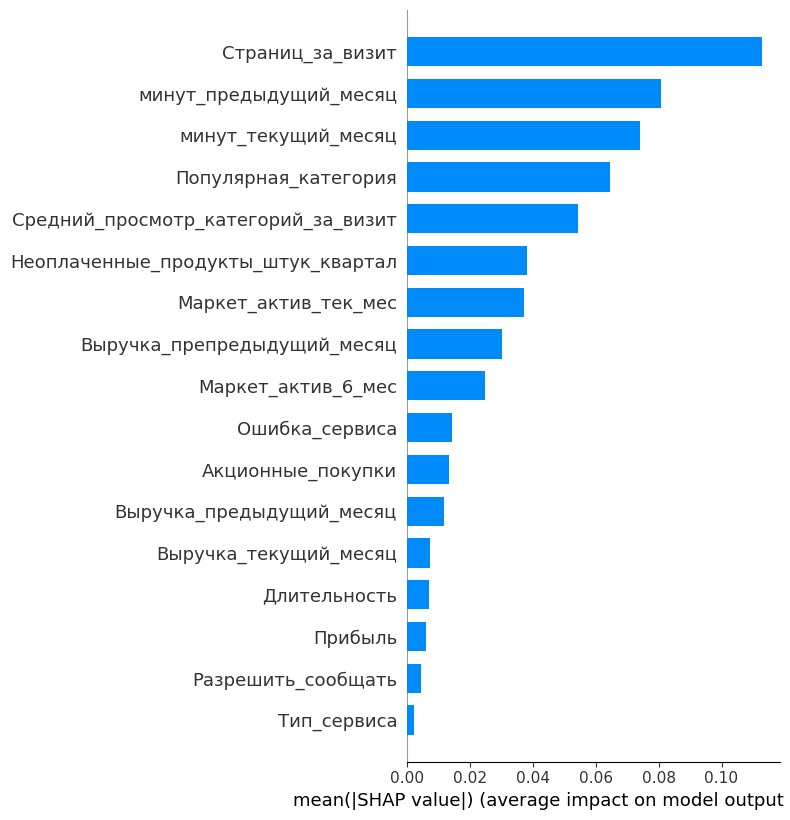

In [84]:
shap.summary_plot(shap_values, plot_type='bar') 

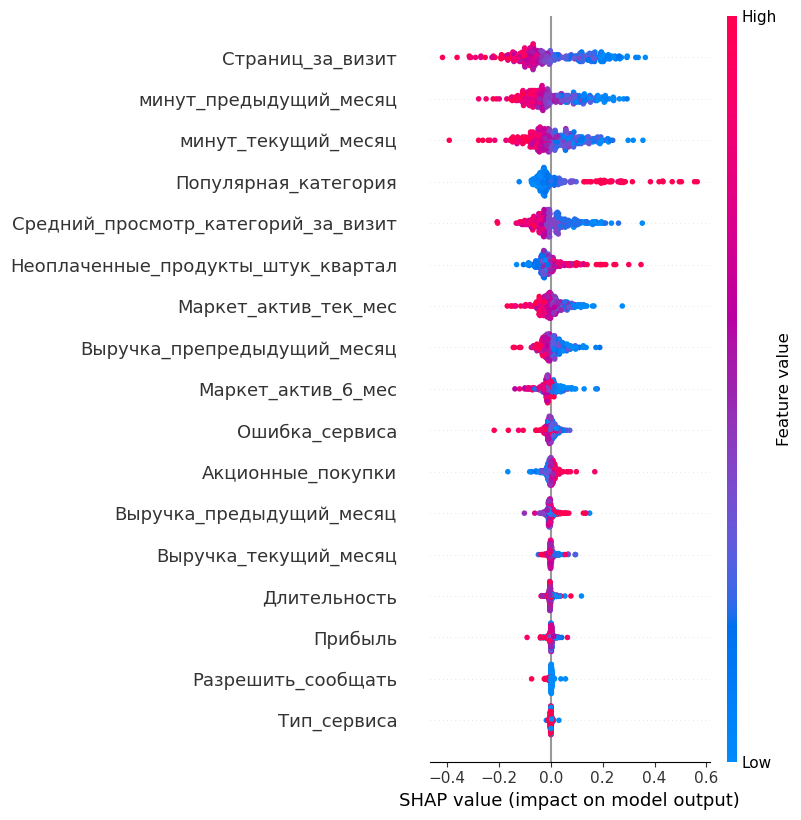

In [85]:
shap.summary_plot(shap_values, X_test_scalled)

Проведенная работа показала, что с точки зрения модели наиболее важными признаками для прогноза активности являются: Страниц_за_визит, минут_предыдущий_месяц, минут_текущий_месяц, Популярная_категория, Средний_просмотр_категорий_за_визит.


## Сегментация покупателей

Рассмотрим сегмент клиентов с высокой вероятностью снижения активности и наиболее высокой прибыльностью

Добавим к датафрейму столбец с вероятностью снижения активности

In [86]:
X_test['Вероятность_снижения'] = grid.predict_proba(X_test)[:, 1]

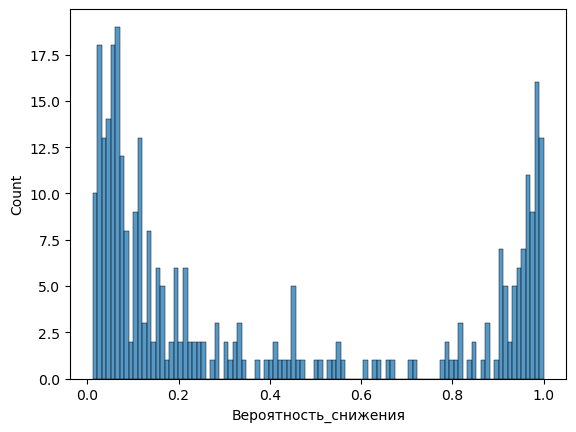

In [87]:
sns.histplot(X_test['Вероятность_снижения'], bins =100);

Рассмотрим и сравним два сегмента: с высокой вероятность снижения активности и с низкой.

In [88]:
X_test_min = X_test[X_test['Вероятность_снижения'] > 0.8]
X_test_max = X_test[X_test['Вероятность_снижения'] < 0.2]

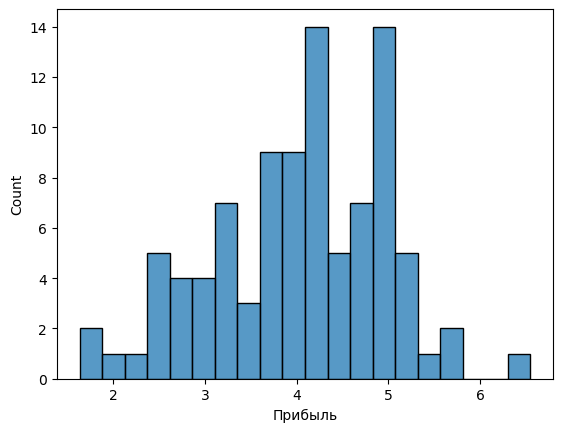

In [89]:
sns.histplot(X_test_min['Прибыль'], bins =20);

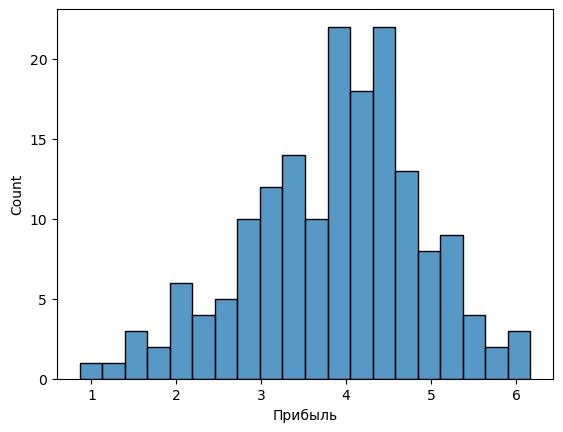

In [90]:
sns.histplot(X_test_max['Прибыль'], bins =20);

Рассмотрим покупателей с высокой прибыльностью

In [91]:
X_test_seg =  X_test_min[X_test_min['Прибыль'] > 4]
X_test_seg1 =  X_test_max[X_test_max['Прибыль'] > 4]

Сравним их средние значения признаков.

In [92]:
X_test_seg1.describe() - X_test_seg.describe() 

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_препредыдущий_месяц,Выручка_предыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Прибыль,Вероятность_снижения
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,1.195450,0.000000,-22.217167,-0.324067,1.219043,-1.878518,0.826454,6.197467,271.989681,-156.905722,-142.418527,5.512195,5.583021,-0.010938,-0.867595
std,-0.329138,0.002315,13.570956,-0.255182,0.141271,-0.574996,-0.054120,1.831098,78.582986,-252.808573,-193.239546,0.554923,1.252630,0.025990,-0.009978
min,2.100000,0.000000,-57.000000,-0.010000,0.000000,0.000000,0.000000,3.000000,219.000000,451.000000,210.900000,2.000000,3.000000,0.000000,-0.787692
25%,1.700000,0.000000,-35.000000,-0.140000,1.000000,-1.000000,1.000000,5.000000,208.250000,115.500000,-4.525000,5.000000,5.000000,0.027500,-0.868742
50%,0.900000,0.000000,-90.500000,-0.150000,1.000000,-2.000000,2.000000,6.000000,231.500000,-116.750000,-210.800000,5.000000,6.000000,-0.140000,-0.899817
75%,1.075000,0.000000,-10.500000,-0.680000,2.000000,-2.250000,1.000000,7.000000,335.250000,-371.875000,-446.475000,6.000000,7.000000,-0.050000,-0.879569
max,0.700000,0.000000,41.000000,-0.550000,1.000000,-4.000000,1.000000,12.000000,634.000000,-417.500000,-209.600000,7.000000,9.000000,-0.380000,-0.807699


In [93]:
X_test_seg1['Популярная_категория'].value_counts()

Популярная_категория
Мелкая бытовая техника и электроника    16
Косметика и аксесуары                   15
Домашний текстиль                       14
Товары для детей                        14
Техника для красоты и здоровья          13
Кухонная посуда                         10
Name: count, dtype: int64

In [94]:
X_test_seg['Популярная_категория'].value_counts()

Популярная_категория
Товары для детей                        16
Домашний текстиль                       11
Косметика и аксесуары                    8
Кухонная посуда                          7
Техника для красоты и здоровья           5
Мелкая бытовая техника и электроника     5
Name: count, dtype: int64

Анализ сегмента с высокой прибыльностью показал, что покупатели, активность которых снижается, покупают в среднем больше акционных товаров, больше не оплачивают продукты.

Также покупатели со снижающейся активностью в среднем меньше просматривают категорий за визит, проводят меньше времени на сайте, меньше страниц за визит посещают.

Вместе с тем покупатели со снижающейся активностью за последние два месяца в среднем принесли больше выручки, чем покупатели с прежним уровнем активности.

Также из сопоставления признака Популярная категория видим, что покупатели со сниженной активностью больше покупают товары из категорий Товары для детей и домашний текстиль, а покупатели с прежним уровнем активности - мелкую бытовую технику и электронику, а также косметику и аксессуары.

В этой связи для повышения активности категории посетителей с высокой прибыльностью предлагаем увеличить количество акций для категорий товаров, где наблюдается "просадка" у посетителей со снижающейся активностью: Техника для красоты и здоровья, Мелкая бытовая техника и электроника.



## Общие выводы

В рамках проекта была поставлена задача о построении модели, прогнозирующей значения целевого параметра Покупательская_активность.
Имеющиеся данные были загружены в датафреймы, данные в таблицах соответствуют описанию.

В рамках предобработки данных были скорректированы названия стобцов датафрейма market_file, исправлены явные ошибки в категориальных признаках.

В рамках проведенного исследовательского анализа были выявлены и устранены покупатели с аномальными значениями в признаке Выручка, остальные данные распределены нормально и равномерно.

Датафреймы market_file, market_money и market_time были объединены по столбцу id с учетом значений в категориальных столбцах и созданием отдельных столбцов в общем датафрейме.

Использование поиска лучшей модели по сетки с использованием пайплайна привело к следующему результату: лучшей моделью стала модель SVC со значением гиперпараметра С равному 1. В качестве лучшего скейлера выбран StandardScaler, в качестве лучшего кодировщика OrdinalEncoder.

Проведенный анализ важности признаков с использванием возможности библиотеки shap показала, что  с точки зрения модели наиболее важными признаками для прогноза активности являются: Страниц_за_визит, минут_предыдущий_месяц, минут_текущий_месяц, Популярная_категория, Средний_просмотр_категорий_за_визит.

Анализ сегмента с высокой прибыльностью показал, что покупатели, активность которых снижается, покупают в среднем больше акционных товаров, больше не оплачивают продукты.

Также покупатели со снижающейся активностью в среднем меньше просматривают категорий за визит, проводят меньше времени на сайте, меньше страниц за визит посещают.

Вместе с тем покупатели со снижающейся активностью за последние два месяца в среднем принесли больше выручки, чем покупатели с прежним уровнем активности.

Также из сопоставления признака Популярная категория видим, что покупатели со сниженной активностью больше покупают товары из категорий Товары для детей и домашний текстиль, а покупатели с прежним уровнем активности - мелкую бытовую технику и электронику, а также косметику и аксессуары.

В этой связи для повышения активности категории посетителей с высокой прибыльностью предлагаем увеличить количество акций для категорий товаров, где наблюдается "просадка" у посетителей со снижающейся активностью: Техника для красоты и здоровья, Мелкая бытовая техника и электроника.
